In [2]:
import numpy as np
import h5py
import cv2 
import os, sys
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

In [3]:
# https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=samsjang&logNo=220601488606

In [5]:
r_data = np.load("../result_data/221005_testdata_FBI_Net_Grayscale_Samsung_SET1_MSE_Affine_layers_x17_filters_x64.npy",mmap_mode='r')
r_data.shape

(1500, 256, 256)

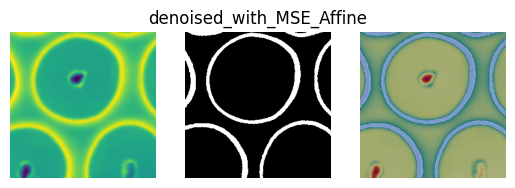

In [8]:
img = r_data[0]
img_uint8 = (r_data[0]*255).astype('uint8')
ret, th1 = cv2.threshold(img_uint8,191,255,cv2.THRESH_BINARY)
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(img_uint8)

plt.subplot(1,3,2)
plt.axis('off')
plt.title('denoised_with_MSE_Affine')
plt.imshow(th1,cmap='gray')

plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(th1,cmap='gray')
plt.imshow(img_uint8,alpha=0.7,cmap='Spectral')

denoised_with_MSE_AFFINE


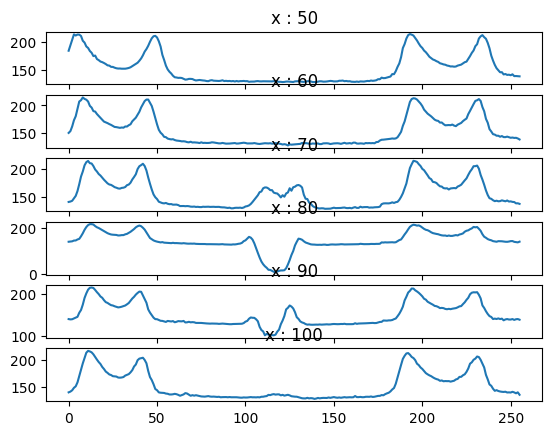

In [9]:
print("denoised_with_MSE_AFFINE")
iter = range(50,101,10)
n = len(iter)
for i,x in enumerate(iter):
    plt.subplot(n,1,i+1)
    plt.title(f'x : {x}')
    plt.plot(img[x]*255)
    #plt.axhline(191,color='r')

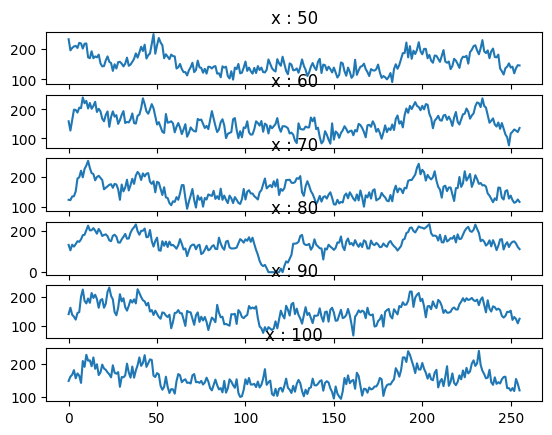

In [12]:
with h5py.File("../../data/test_Samsung_SNU_patches_SET1.hdf5", 'r') as f:
    clean_images = np.array(f['clean_images'])
    noisy_images = np.array(f['noisy_images'])
iter = range(50,101,10)
n = len(iter)
for i,x in enumerate(iter):
    plt.subplot(n,1,i+1)
    plt.title(f'x : {x}')
    plt.plot(clean_images[0][x]*255)

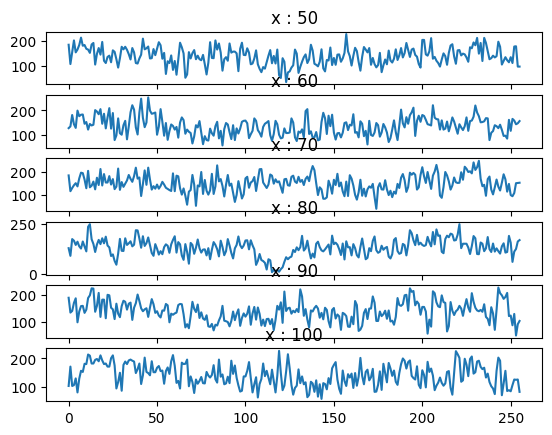

In [13]:
iter = range(50,101,10)
n = len(iter)
for i,x in enumerate(iter):
    plt.subplot(n,1,i+1)
    plt.title(f'x : {x}')
    plt.plot(noisy_images[0][x]*255)

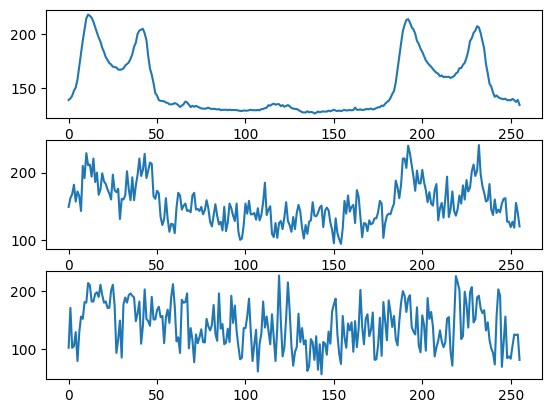

In [15]:
x = 100
plt.subplot(311)
plt.plot(r_data[0][x]*255)
plt.subplot(312)
plt.plot(clean_images[0][x]*255)
plt.subplot(313)
plt.plot(noisy_images[0][x]*255)

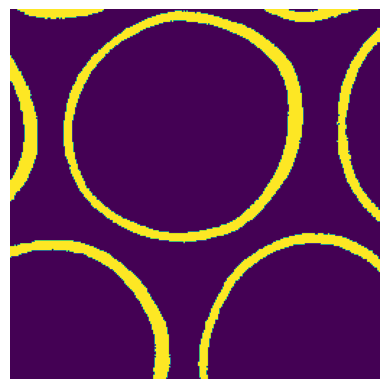

In [62]:
plt.axis('off')
plt.imshow(th1)

In [64]:
ret2, th2 = cv2.threshold(img_uint8, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

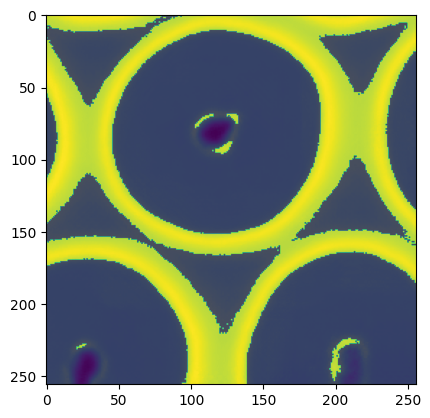

In [66]:
plt.imshow(th2)
plt.imshow(img_uint8,alpha=0.4)

In [67]:
ret2, th2 = cv2.threshold(img_uint8, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

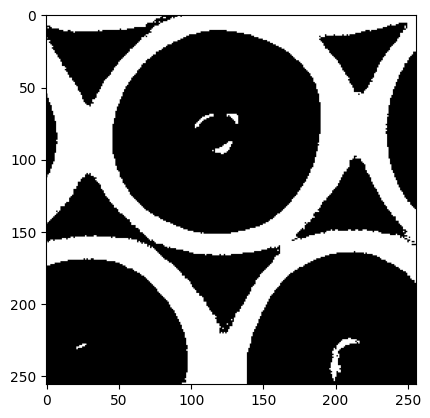

In [69]:
plt.imshow(th2,cmap='gray')

In [80]:
kernel = np.ones((3,3))
opening = cv2.morphologyEx(th2, cv2.MORPH_OPEN, kernel, iterations=3)

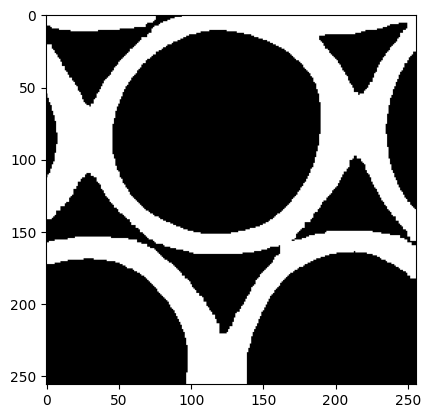

In [81]:
plt.imshow(opening,cmap='gray')

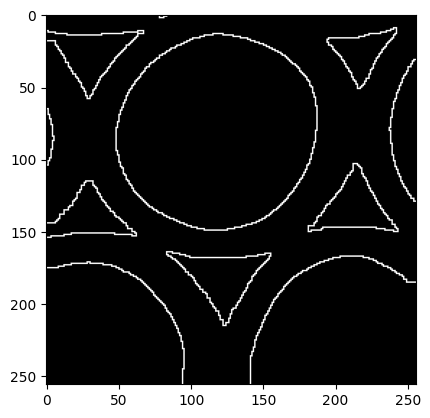

In [84]:
border = cv2.dilate(opening,kernel, iterations=3)
border = border - cv2.erode(border,None)
plt.imshow(border,cmap='gray')

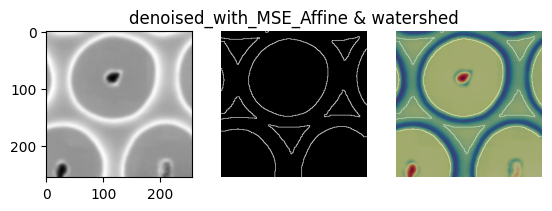

In [123]:
plt.subplot(1,3,1)
# plt.axis('off')
plt.imshow(img_uint8,cmap='gray')

plt.subplot(1,3,2)
plt.axis('off')
plt.title('denoised_with_MSE_Affine & watershed')
plt.imshow(border,cmap='gray')

plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(border,cmap='gray')
plt.imshow(img_uint8,alpha=0.7,cmap='Spectral')

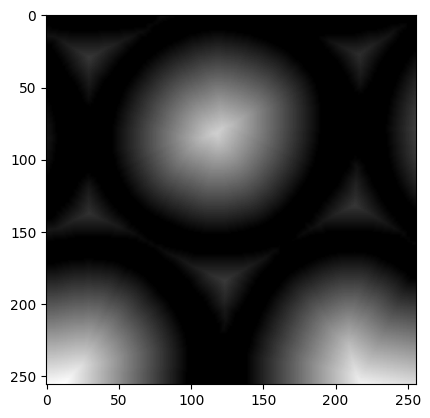

In [88]:
dt = cv2.distanceTransform(~opening,cv2.DIST_L2,5)
dt = ((dt-dt.min()) / (dt.max()-dt.min())*255).astype(np.uint8)
plt.imshow(dt,cmap='gray')

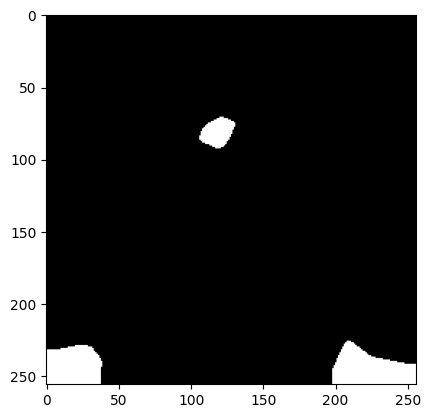

In [92]:
ret,th3 = cv2.threshold(dt, 180, 255, cv2.THRESH_BINARY)
plt.imshow(th3,cmap='gray')

In [7]:
from scipy.ndimage import label
marker, ncc = label(th3)
marker = marker * (255/ncc)
marker[border==255] = 255
marker = marker.astype(np.int32)
img_uint8 = img_uint8.astype(np.uint8)
print(marker.dtype, img_uint8.dtype)
cv2.watershed(img_uint8, marker)
plt.imshow(marker,cmap='gray')

NameError: name 'th3' is not defined

In [110]:
img_uint8.dtype, marker.dtype

(dtype('int32'), dtype('int32'))

In [134]:
from skimage.segmentation import watershed

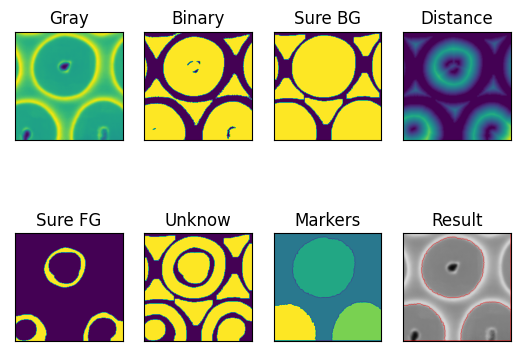

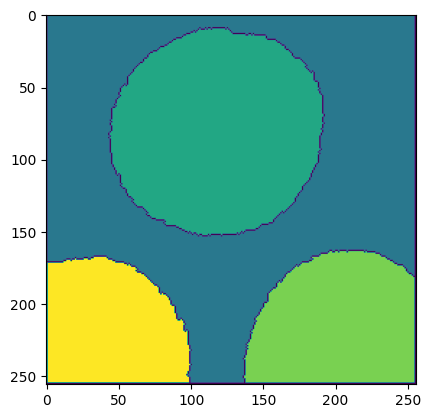

In [5]:
# https://opencv-python.readthedocs.io/en/latest/doc/27.imageWaterShed/imageWaterShed.html
import cv2
import numpy as np
from matplotlib import pyplot as plt


# img = cv2.imread('images/watershed.jpg')

gray = img_uint8
b = np.zeros((256,256,3)).astype('uint8')
b[:,:,0] = img_uint8
b[:,:,1] = img_uint8
b[:,:,2] = img_uint8

# binaray image로 변환
#gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#Morphology의 opening, closing을 통해서 노이즈나 Hole제거
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)

# dilate를 통해서 확실한 Backgroud
sure_bg = cv2.dilate(opening,kernel,iterations=3)

#distance transform을 적용하면 중심으로 부터 Skeleton Image를 얻을 수 있음.
# 즉, 중심으로 부터 점점 옅어져 가는 영상.
# 그 결과에 thresh를 이용하여 확실한 FG를 파악
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)

# Background에서 Foregrand를 제외한 영역을 Unknown영역으로 파악
unknown = cv2.subtract(sure_bg, sure_fg)

# FG에 Labelling작업
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# watershed를 적용하고 경계 영역에 색지정
markers = cv2.watershed(b,markers)
b[markers == -1] = [255,0,0]


images = [gray,thresh,sure_bg,  dist_transform, sure_fg, unknown, markers, b]
titles = ['Gray','Binary','Sure BG','Distance','Sure FG','Unknow','Markers','Result']

for i in range(len(images)):
    plt.subplot(2,4,i+1),plt.imshow(images[i]),plt.title(titles[i]),plt.xticks([]),plt.yticks([])

plt.show()
plt.imshow(markers)

In [ ]:
markers[100][180:190]

array([ 2,  2,  2,  2,  2,  2,  2,  2, -1,  1], dtype=int32)

# Let's do on full image

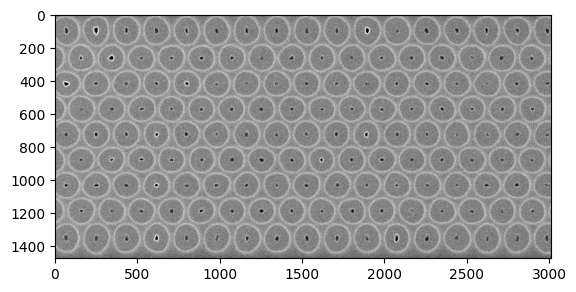

In [61]:
import cv2
image_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned/SET1/F8_8.png"
full_img = cv2.imread(image_path)
plt.imshow(full_img)

In [28]:
full_img.shape, full_img.dtype

((1474, 3010, 3), dtype('uint8'))

(1474, 3010, 3) (1474, 3010)


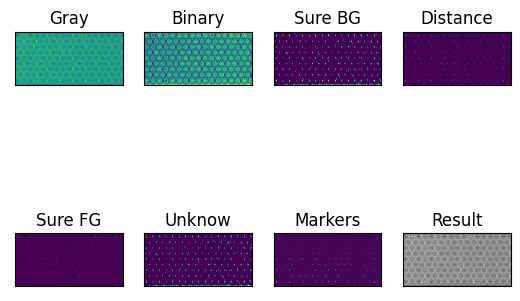

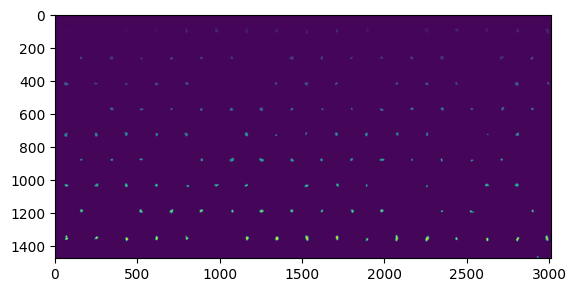

In [64]:
# https://opencv-python.readthedocs.io/en/latest/doc/27.imageWaterShed/imageWaterShed.html
import cv2
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy as dcpy


# img = cv2.imread('images/watershed.jpg')

gray = full_img[:,:,0]

# binaray image로 변환
#gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(dcpy(gray),0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#Morphology의 opening, closing을 통해서 노이즈나 Hole제거
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)

# dilate를 통해서 확실한 Backgroud
sure_bg = cv2.dilate(opening,kernel,iterations=3)

#distance transform을 적용하면 중심으로 부터 Skeleton Image를 얻을 수 있음.
# 즉, 중심으로 부터 점점 옅어져 가는 영상.
# 그 결과에 thresh를 이용하여 확실한 FG를 파악
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)

# Background에서 Foregrand를 제외한 영역을 Unknown영역으로 파악
unknown = cv2.subtract(sure_bg, sure_fg)

# FG에 Labelling작업
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

print(full_img.shape,markers.shape)
# watershed를 적용하고 경계 영역에 색지정
markers = cv2.watershed(full_img,markers)
full_img[markers == -1] = [255,0,0]


images = [gray,thresh,sure_bg,  dist_transform, sure_fg, unknown, markers, full_img]
titles = ['Gray','Binary','Sure BG','Distance','Sure FG','Unknow','Markers','Result']

for i in range(len(images)):
    plt.subplot(2,4,i+1),plt.imshow(images[i]),plt.title(titles[i]),plt.xticks([]),plt.yticks([])

plt.show()
plt.imshow(markers)

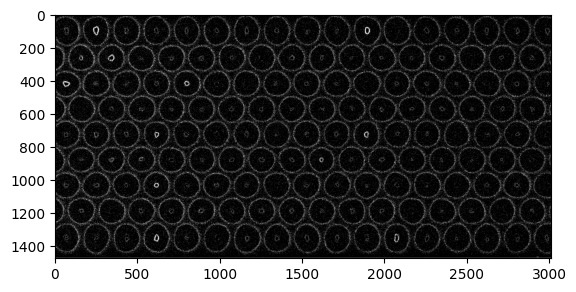

In [65]:

gray = full_img[:,:,0]

# binaray image로 변환
#gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, th1 = cv2.threshold(dcpy(gray),200,255,cv2.THRESH_BINARY)
# ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(th1,cmap='gray')

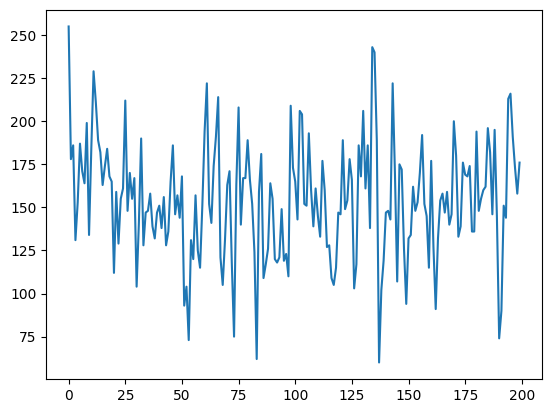

In [79]:
plt.plot(gray[150][:200])

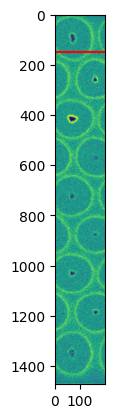

In [81]:
plt.imshow(gray[:,:200])
plt.axhline(150,color='r')
